# Imort Part:

In [1]:
"""
TRAINING OF THE U-net FOR INPAINTING AND SUPER-RESOLUTION

1) Train, validate and test the U-net on the available datasets:
    - Dataset_xf
    - Dataset_yf
    - Dataset_xy
   Each 2D image is normalised by the maximum before testing.

2) The Dataset is divided as follows:
    - 80% Train set
    - 10% Validation set
    - 10% Test set

2) Both the weights of the trained network and the loss history are
   saved with pickle, in order to both retrain the network using the wiìeight 
   of last training and to visualize losses

2) Compute and save the costum metrics as: nmse, psnr
   both for couples:
   - (ground truth,learned image)
   - (ground truth, interpolated image)
   To compare performances of the U-net with respect to a classic interpolator

"""
import numpy as np
from scipy.special import boxcox
import pickle
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import keras as keras
import keras.callbacks as cb
from keras import Model
from tensorflow.keras.models import load_model
from Model_Unet import *
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from CustomMetricsLosses import *
from scipy.interpolate import interp2d
import argparse
import os
from random import sample
from scipy.signal import resample

# usa gpu con più memoria libera
import GPUtil


## Crea sessione tensorflow:

In [2]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import clear_session

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2829831221924903479
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7556019008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15185899066971588160
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:04:00.0, compute capability: 6.1"
]


In [3]:
config=tf.compat.v1.ConfigProto()
session = tf.compat.v1.Session(config=config)

## Function part:

In [4]:
# Reset Keras Session
def reset_keras(sess):
	clear_session()
	sess.close()

def clip_normalize_power(in_content, mi, mx, p):
    """
    :param in_content: data to be processed
    :param mi: min value for clipping
    :param mx: max value for clipping
    :param p: exponent for the power function
    :return: normalized hard clipped image
    """
    in_content = np.clip(in_content, a_min=mi, a_max=mx) #hard clip
    in_content = 2 * (in_content - in_content.min()) / (in_content.max() - in_content.min()) - 1
    in_content = np.power(np.abs(in_content), p)
    return in_content

def sigm_clip(in_content, mi, mx, p):
    """
    :param in_content: data to be processed
    :param mi: min value for sigmoid function
    :param mx: max value for sigmoid function
    :param p: exponent for the power function
    :return: normalized soft clipped image
    """
    in_content =  mi + (mx-mi)*(lambda t: (1+300**(-t+0.5))**(-1) )( (in_content-mi)/(mx-mi) )  #sigmoid soft clip
    in_content = 2 * (in_content - mi) / (mx - mi) - 1
    in_content = np.power(np.abs(in_content), p)
    return in_content

def inv_sigm_clip(in_content, mi, mx, p):
    """
    :param in_content: data to be processed
    :param mi: min value used for inverting sigmoid
    :param mx: max value used for inverting sigmoid
    :param p: exponent for the power function (to be inverted)
    :return: original image
    """
    in_content = np.power(np.abs(in_content), 1/p)
    #in_content = (in_content + 1) * (mx - mi) / 2 + mi
    t = np.log((mx-mi)/(in_content-mi)-1)/np.log(300)
    in_content = mi + (mx-mi)*(0.5-t)
    return in_content

def invertible_clipping(in_content, mi, mx, p):
	"""
    :param in_content: data to be processed
    :param mi: min value for sigmoid function
    :param mx: max value for sigmoid function
    :param p: exponent for the power function
    :return: normalized soft clipped image
    """
	image_clip = np.zeros(in_content.shape)
    #Forward Clipping
	i,j = np.where(in_content < mi)
	image_clip[i, j] = 1e-4 * in_content[i, j] + (1 - 1e-4) * mi
	i,j = np.where(in_content > mx)
	image_clip[i, j] = 1e-4 * in_content[i, j] + (1 - 1e-4) * mx
	i,j = np.where((in_content >= mi) & (in_content <= mx))
	image_clip[i, j] = in_content[i, j]

	#Forward Normalization
	#real_mx = 1e-4 *1 + (1 - 1e-4) * mx
	#image_clip_norm = image_clip/real_mx
	image_clip_norm = 2 * (image_clip - mi) / (mx - mi) - 1

	#Forward Power
	image_clip_pow = np.power(np.abs(image_clip_norm), p)
	return image_clip_pow

def inv_invertible_clipping(in_content, mi, mx, p):
	#Backward Power
	image_inv_pow = np.power(np.abs(in_content), 1/p)

	#Backward Normalization
	real_mx = 1e-4 *1 + (1 - 1e-4) * mx
	image_inv_norm = image_inv_pow*real_mx
	#image_inv_norm = (image_inv_pow + 1) * (mx - mi) / 2 + mi

	#Backward Clipping
	image_inv = np.zeros(image_inv_norm.shape)

	i,j = np.where(image_inv_norm < mi)
	image_inv[i, j] = (image_inv_norm[i, j] - (1 - 1e-4) * mi) / 1e-4
	i,j = np.where(image_inv_norm > mx)
	image_inv[i, j] = (image_inv_norm[i, j] - (1 - 1e-4) * mx) / 1e-4
	i,j = np.where((image_inv_norm >= mi) & (image_inv_norm <= mx))
	image_inv[i, j] = image_inv_norm[i, j]
	return image_inv

def bc_clip(image, lam):
    bc_image = boxcox(image, lam)
    bc_min = bc_image.min()
    bc_max = bc_image.max()
    bc_image = (bc_image - bc_min) / (bc_max - bc_min)   
    return (bc_image, bc_min, bc_max)

def inv_bc_clip(image, mi, mx, lam):
    bc_image = image * (mx - mi) + mi
    bc_image = inv_boxcox(bc_image, lam)
    return bc_image

def normalize(in_content):
	in_content_abs = np.abs(in_content)
	in_content_norm = in_content_abs/in_content_abs.max()
	return in_content_norm

## Dataset Part(prepare&split):

# TEST  PART

In [18]:
import sys
# print(sys.path)

imagetype = 'xy'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
print("=================imageType = xy=================")
print("size of the dati[1][6]: ",sys.getsizeof(dati[1][6]),"bytes")
print("shape of the dati[1][6]: ",[len(a) for a in dati[1][6]])
print("type of the dati[1][6]: ",type(dati[1][6]))
print("shape of the dati[1][6]: ",np.shape(dati[1][6]))

print("size of the dati: ",sys.getsizeof(dati),"bytes")
# print("shape of the dati: ",[len(a) for a in dati])
print("type of the dati: ",type(dati))
print("shape of the dati: ",np.shape(dati))
print("================================================\n")


imagetype = 'xf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
print("=================imageType = xf=================")
print("size of the dati[1][6]: ",sys.getsizeof(dati[1][6]),"bytes")
print("shape of the dati[1][6]: ",[len(a) for a in dati[1][6]])
print("type of the dati[1][6]: ",type(dati[1][6]))
print("shape of the dati[1][6]: ",np.shape(dati[1][6]))

print("size of the dati: ",sys.getsizeof(dati),"bytes")
# print("shape of the dati: ",[len(a) for a in dati])
print("type of the dati: ",type(dati))
print("shape of the dati: ",np.shape(dati))
print("================================================\n")


imagetype = 'yf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
print("=================imageType = yf=================")
print("size of the dati[1][6]: ",sys.getsizeof(dati[1][6]),"bytes")
print("shape of the dati[1][6]: ",[len(a) for a in dati[1][6]])
print("type of the dati[1][6]: ",type(dati[1][6]))
print("shape of the dati[1][6]: ",np.shape(dati[1][6]))

print("size of the dati: ",sys.getsizeof(dati),"bytes")
# print("shape of the dati: ",[len(a) for a in dati])
print("type of the dati: ",type(dati))
print("shape of the dati: ",np.shape(dati))
print("================================================\n")


imagetype = 'xyf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
print("=================imageType = xyf=================")
print("size of the dati[1][5]: ",sys.getsizeof(dati[1][5]),"bytes")
print("shape of the dati[1][5]: ",[len(a) for a in dati[1][5]])
print("type of the dati[1][5]: ",type(dati[1][5]))
print("shape of the dati[1][5]: ",np.shape(dati[1][5]))

print("size of the dati: ",sys.getsizeof(dati),"bytes")
# print("shape of the dati: ",[len(a) for a in dati])
print("type of the dati: ",type(dati))
print("shape of the dati: ",np.shape(dati))
print("================================================\n")



# Imports PIL module 
# from PIL import Image
# # open method used to open different extension image file
# img1 = dati[1][6]
# im = Image.open(img1) 
# # This method will show image in any image viewer 
# im.show() 

=================imageType = xy=================
size of the dati[1][6]:  128 bytes
shape of the dati[1][6]:  [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
type of the dati[1][6]:  <class 'numpy.ndarray'>
shape of the dati[1][6]:  (16, 64)
size of the dati:  1764088 bytes
type of the dati:  <class 'list'>
shape of the dati:  (218568, 7)

=================imageType = xf=================
size of the dati[1][6]:  128 bytes
shape of the dati[1][6]:  [1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
type of the dati[1][6]:  <class 'numpy.ndarray'>
shape of the dati[1][6]:  (64, 1024)
size of the dati:  21560 bytes
type of the dati:  <class 'li

In [19]:
np.shape(dati[1][5][1])

(64, 1024)

### xy plot:

In [ ]:
imagetype = 'xy'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
# print("=================imageType = xy=================")
# print("size of the dati[1][6]: ",sys.getsizeof(dati[1][6]),"bytes")
# print("shape of the dati[1][6]: ",[len(a) for a in dati[1][6]])
# print("type of the dati[1][6]: ",type(dati[1][6]))
# print("shape of the dati[1][6]: ",np.shape(dati[1][6]))

# print("size of the dati: ",sys.getsizeof(dati),"bytes")
# # print("shape of the dati: ",[len(a) for a in dati])
# print("type of the dati: ",type(dati))
# print("shape of the dati: ",np.shape(dati))
# print("================================================\n")

In [ ]:
print("shape(dati[0][6]): ",np.shape(dati[0][6])) 
print("dati[0][6]: ",dati[0][6]) 


input_img = dati[0][6]
target_img = dati[0][6]


plt.subplot(121), plt.title('Input xy image')
# plt.imshow(input_img, cmap='bone', aspect='auto'), plt.colorbar()
plt.imshow(np.clip(input_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto'), plt.colorbar()
plt.xlabel('X'), plt.ylabel('Y')
plt.grid(None)

plt.subplot(122), plt.title('Target xy image')
# plt.imshow(target_img, cmap='bone', aspect='auto'), plt.colorbar()
plt.imshow(np.clip(target_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto'), plt.colorbar()
plt.xlabel('X'), plt.ylabel('Y')
plt.grid(None)

plt.show()

### xf plot :

In [ ]:
imagetype = 'xf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
# print("=================imageType = xf=================")
# print("size of the dati[1][6]: ",sys.getsizeof(dati[1][6]),"bytes")
# print("shape of the dati[1][6]: ",[len(a) for a in dati[1][6]])
# print("type of the dati[1][6]: ",type(dati[1][6]))
# print("shape of the dati[1][6]: ",np.shape(dati[1][6]))

# print("size of the dati: ",sys.getsizeof(dati),"bytes")
# # print("shape of the dati: ",[len(a) for a in dati])
# print("type of the dati: ",type(dati))
# print("shape of the dati: ",np.shape(dati))
# print("================================================\n")


print("shape(dati[0][6]): ",np.shape(dati[0][6])) 
print("dati[0][6]: ",dati[0][6]) 


input_img = dati[0][6]
target_img = dati[0][6]


plt.subplot(121), plt.title('Input xf image')
plt.imshow(np.clip(input_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
# plt.imshow(input_img, cmap='bone', aspect='auto'), plt.colorbar()
plt.xlabel('X'), plt.ylabel('F')
plt.grid(None)

plt.subplot(122), plt.title('Target xf image')
plt.imshow(np.clip(target_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto'), plt.colorbar()
# plt.imshow(target_img, cmap='bone', aspect='auto'), plt.colorbar()
plt.xlabel('X'), plt.ylabel('F')
plt.grid(None)

plt.show()

### yf plot :

shape(dati[0][6]):  (16, 1024)


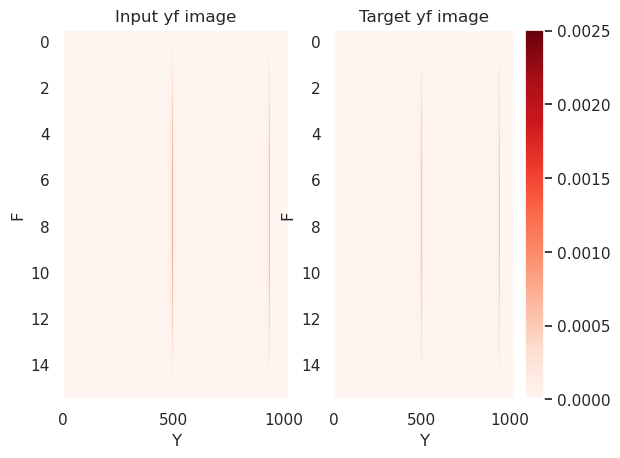

In [23]:
imagetype = 'yf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
# print("=================imageType = yf=================")
# print("size of the dati[1][6]: ",sys.getsizeof(dati[1][6]),"bytes")
# print("shape of the dati[1][6]: ",[len(a) for a in dati[1][6]])
# print("type of the dati[1][6]: ",type(dati[1][6]))
# print("shape of the dati[1][6]: ",np.shape(dati[1][6]))

# print("size of the dati: ",sys.getsizeof(dati),"bytes")
# # print("shape of the dati: ",[len(a) for a in dati])
# print("type of the dati: ",type(dati))
# print("shape of the dati: ",np.shape(dati))
# print("================================================\n")



print("shape(dati[0][6]): ",np.shape(dati[0][6])) 
# print("dati[0][6]: ",dati[0][6]) 


input_img = dati[1][6]
target_img = dati[1][6]


plt.subplot(121), plt.title('Input yf image')
# plt.imshow(input_img, cmap='bone', aspect='auto'), plt.colorbar()
plt.imshow(np.clip(input_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('Y'), plt.ylabel('F')
plt.grid(None)

plt.subplot(122), plt.title('Target yf image')
# plt.imshow(target_img, cmap='bone', aspect='auto'), plt.colorbar()
plt.imshow(np.clip(target_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto'), plt.colorbar()
plt.xlabel('Y'), plt.ylabel('F')
plt.grid(None)

plt.show()

### xyf plot :

In [21]:
imagetype = 'xyf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
    
dati = pickle.load(data)
# print("=================imageType = xyf=================")
# print("size of the dati[1][1]: ",sys.getsizeof(dati[1][1]),"bytes")
# print("shape of the dati[1][1]: ",[len(a) for a in dati[1][1]])
# print("type of the dati[1][1]: ",type(dati[1][1]))
# print("shape of the dati[1][1]: ",np.shape(dati[1][1]))

# print("size of the dati: ",sys.getsizeof(dati),"bytes")
# # print("shape of the dati: ",[len(a) for a in dati])
# print("type of the dati: ",type(dati))
# print("shape of the dati: ",np.shape(dati))
# print("================================================\n")

print("shape(dati[0][5])",np.shape(dati[0][5])) 
# print("dati[0][5]",dati[0][5]) 
input_img = dati[0][5]
target_img = dati[0][5]

plt.figure(figsize=(20,12))
plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=2.0,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.subplot(151), plt.title('Input xyf image')
plt.imshow(np.clip(input_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('X [m]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.subplot(152), plt.title('Target xyf image')
plt.imshow(np.clip(target_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('X [m]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.subplot(153), plt.title('Input xyf image')
plt.imshow(np.clip(input_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('X [m]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.subplot(154), plt.title('Target xyf image')
plt.imshow(np.clip(target_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('X [m]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.subplot(155), plt.title('Target xyf image')
plt.imshow(np.clip(target_img, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto'), plt.colorbar()
plt.xlabel('X [m]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.show()


# plt.subplot(141), plt.title('Target')
# plt.imshow(np.clip(ground_truth, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
# plt.xlabel('Freq [Hz]'), plt.ylabel('X [m]')
# plt.grid(None)


# plt.subplot(142), plt.title('U-net input')
# plt.imshow(np.clip(down, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
# plt.xlabel('Freq [Hz]')
# plt.grid(None)
# plt.subplot(143), plt.title('Interp input')
# plt.imshow(np.clip(ds_image, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
# plt.xlabel('Freq [Hz]')
# plt.grid(None)
# plt.subplot(144), plt.title('Interp output')
# plt.imshow(np.clip(interp_image, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
# plt.xlabel('Freq [Hz]')
# plt.grid(None)
# plt.show()

shape(dati[0][5]) (16, 64, 1024)


TypeError: Invalid shape (16, 64, 1024) for image data

### 4 in 1 plot

In [ ]:
imagetype = 'xy'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
dati = pickle.load(data)
imgxy = dati[0][6]

imagetype = 'xf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb') 
dati = pickle.load(data)
imgxf = dati[0][6]


imagetype = 'yf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
dati = pickle.load(data)
imgyf = dati[0][6]


imagetype = 'xyf'
datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'
data = open(datapath+'1', 'rb')
dati = pickle.load(data)
imgxyf = dati[0][5][1]

In [ ]:
plt.figure(figsize=(30, 12))
plt.subplot(141), plt.title('Target xy image')
plt.imshow(np.clip(imgxy, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('X [m]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.subplot(142), plt.title('Target xf image')
plt.imshow(np.clip(imgxf, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('Freq[Hz]'), plt.ylabel('X [m]')
plt.grid(None)
plt.subplot(143), plt.title('Target yf image')
plt.imshow(np.clip(imgyf, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
plt.xlabel('Freq[Hz]'), plt.ylabel('Y [m]')
plt.grid(None)
plt.subplot(144), plt.title('Target xyf image')
plt.imshow(np.clip(imgxyf, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto'), plt.colorbar()
plt.xlabel('Freq[Hz]'), plt.ylabel('XY [m]')
plt.grid(None)
plt.show()

In [ ]:
def prepareDataset(imagetype,init,end,down_factor,snr_dB,downsampling,num_x_points,num_y_points,num_freqs):

	x = np.arange(0,num_x_points,1).tolist()
	y = np.arange(0,num_y_points,1).tolist()

	images = []
	zero_lines_idxs = []
	counter_array = np.arange(init,end+1,1)

	datapath = './dataset/DatasetFiles/Dataset_'+imagetype+'/Dataset_'+imagetype+'_'

	for count in counter_array:
		with open(datapath+str(count), 'rb') as data:
			dati = pickle.load(data)

		perc=10

		print('')
		print('Preparing '+datapath+str(count))
		print('')

		for i in range(len(dati)):
			percentage= round((i/len(dati))*100,0)
			if percentage==perc:
				print('Percentage: '+str(perc)+'%')
				perc = perc+10

			target_img = np.array(dati[i][6])
			input_img = np.array(dati[i][6])

			#addition of noise
			if snr_dB>0:
				if i==0:
					print('')
					print('Adding '+str(snr_dB)+' dB noise to input images')
					print('')
				power = np.mean(input_img ** 2)
				var = power / (10 ** (snr_dB / 10))
				noise = np.random.normal(0, np.sqrt(var), np.shape(input_img))
				input_img = input_img+noise

			if datapath=='./dataset/DatasetFiles/Dataset_xy/Dataset_xy_':
				if downsampling=='random':
					if down_factor==2:
						x_sampled_list = sample(x,k=int(num_x_points*(1/down_factor)))
						
					else:
						if down_factor==4:
							x_sampled_list = sample(x,k=int(num_x_points*(2/down_factor)))
							y_sampled_list = sample(y,k=int(num_y_points*(2/down_factor)))

						else:
							x_sampled_list = sample(x,k=int(num_x_points*(2/down_factor)))
							y_sampled_list = sample(y,k=int(num_y_points*(4/down_factor)))

						y_sampled_list.sort()

					x_sampled_list.sort()

					if down_factor==2:
						sampled_list = x_sampled_list
						i=0
						for idx in x:
							if i==num_x_points*(1/down_factor):
								break
							elif idx!=sampled_list[i]:
								input_img[:,idx]=np.zeros(num_y_points)
							else:
								i=i+1
					else:
						sampled_list = x_sampled_list+y_sampled_list
						x_down_factor=down_factor/2

						i=0

						for idx in x:
							if i==int(num_x_points*(1/x_down_factor)):
								break
							elif idx!=sampled_list[i]:
								input_img[:,idx]=np.zeros(num_y_points)
							else:
								i=i+1
						for idy in y:
							if i==len(sampled_list):
								break
							elif idy!=sampled_list[i]:
								input_img[idy,:]=np.zeros(num_x_points)
							else:
								i=i+1

				elif downsampling=='regular':

					if down_factor==2:
						sampled_list = x[::down_factor]

						for idx in x:
							if idx%down_factor!=0:
								input_img[:,idx]=np.zeros(num_y_points)

					else:
						x_down_factor = int(down_factor/2)
						if down_factor==4:
							y_down_factor = x_down_factor
							sampled_list = x[::x_down_factor]+y[::y_down_factor]
						else:
							y_down_factor = int(x_down_factor/2)
							sampled_list = x[::x_down_factor]+y[::y_down_factor]

						for idx in x:
							if idx%x_down_factor!=0:
								input_img[:,idx]=np.zeros(num_y_points)

						for idy in y:
							if idy%y_down_factor==0:
								input_img[idy,:]=np.zeros(num_x_points)
				
				#print(sampled_list)
			
			elif datapath=='./dataset/DatasetFiles/Dataset_yf/Dataset_yf_':
				if downsampling=='random':
					sampled_list = sample(y,k=int(num_y_points*(1-1/down_factor)))
					sampled_list.sort()
					i=0
					for idx in y:
						if i==len(sampled_list):
							break
						elif idx==sampled_list[i]:
							input_img[idx,:]=np.zeros(num_freqs)
							i=i+1
				elif downsampling=='regular':
					for idy in y:
						if idy%down_factor!=0:
							input_img[idy,:]=np.zeros(num_freqs)

			elif datapath=='./dataset/DatasetFiles/Dataset_xf/Dataset_xf_':

				if num_x_points<64: #it means the image is real
					target_img = np.array(dati[i][6][16:16+32,:])
					input_img = np.array(dati[i][6][16:16+32,:])

				if downsampling=='random':
					sampled_list = sample(x,k=int(num_x_points*(1/down_factor)))
					sampled_list.sort()

					i=0
					for idx in x:
						if i==num_x_points*(1/down_factor):
							break
						elif idx!=sampled_list[i]:
							input_img[idx,:]=np.zeros(num_freqs)
						else:
							i=i+1

				elif downsampling=='regular':
					sampled_list = x[::down_factor]

					for idx in x:
						if idx%down_factor!=0:
							input_img[idx,:]=np.zeros(num_freqs)
			
            
            
            
            
            
			if imagetype!='xy' and np.mean(target_img**2)>1e-10:
				images.append((input_img,target_img))
				zero_lines_idxs.append(sampled_list)

				'''plt.subplot(121), plt.title('Input xy image')
				plt.imshow(input_img, cmap='bone', aspect='auto'), plt.colorbar()
				plt.xlabel('X [m]'), plt.ylabel('Y [m]')
				plt.grid(None)
				plt.subplot(122), plt.title('Target xy image')
				plt.imshow(target_img, cmap='bone', aspect='auto'), plt.colorbar()
				plt.xlabel('X [m]'), plt.ylabel('Y [m]')
				plt.grid(None)
				plt.show()'''

	### ADD CHANNEL DIMENSION

	print('')
	print('Dataset ready to be splitted --> '+str(len(images))+' images')
	print('')

	images = np.array(images)
	if datapath=='./dataset/DatasetFiles/Dataset_xf/Dataset_xf_':
		images = images.reshape(len(images),2,num_x_points,num_freqs,1)
	elif datapath=='./dataset/DatasetFiles/Dataset_yf/Dataset_yf_':
		images = images.reshape(len(images),2,num_y_points,num_freqs,1)
	elif datapath=='./dataset/DatasetFiles/Dataset_xy/Dataset_xy_':
		images = images.reshape(len(images),2,num_y_points,num_x_points,1)

	return images, zero_lines_idxs

def splitDataset(dataset,zero_lines_idxs,batch_size,lam):
	### DIVIDING THE DATASET INTO TRAIN, VALIDATION AND TEST SETS
	shuffler = np.random.permutation(len(dataset))

	dataset = np.array(dataset, dtype='float32')
	zero_lines_idxs = np.array(zero_lines_idxs)

	dataset = dataset[shuffler]
	zero_lines_idxs = zero_lines_idxs[shuffler]

	train, val, test = np.split(dataset,[int(.8 * len(dataset)),int(.9 * len(dataset))])
	train_zli, val_zli, test_zli = np.split(zero_lines_idxs,[int(.8 * len(zero_lines_idxs)),int(.9 * len(zero_lines_idxs))])

	X_train = []
	Y_train = []

	print("Preparing training set ")
	train_samples = len(train)-len(train)%batch_size
	for idx in range(train_samples):
		'''input_img_eq, mini, maxi = bc_clip(train[idx][0],lam)
		target_img_eq, mint, maxt = bc_clip(train[idx][1],lam)'''
		X_train.append(normalize(train[idx][0]))
		Y_train.append(normalize(train[idx][1]))
		'''X_train.append(input_img_eq)
		Y_train.append(target_img_eq)'''

	X_train = np.array(X_train)
	Y_train = np.array(Y_train)

	print("Training sets ready :"+str(np.shape(X_train)))
	print('')

	X_val = []
	Y_val = []

	print("Preparing validation set ")
	val_samples = len(val)-len(val)%batch_size
	for idx in range(val_samples):
		'''input_img_eq, mini, maxi = bc_clip(val[idx][0],lam)
		target_img_eq, mint, maxt = bc_clip(val[idx][1],lam)'''
		X_val.append(normalize(val[idx][0]))
		Y_val.append(normalize(val[idx][1]))
		'''X_val.append(input_img_eq)
		Y_val.append(target_img_eq)'''

	X_val = np.array(X_val)
	Y_val = np.array(Y_val)

	print("Validation set ready :"+str(np.shape(X_val)))
	print('')

	X_test = []
	Y_test = []
	X_test_noeq = []
	Y_test_noeq = []
	dynamics = []

	print("Preparing test set ")
	test_samples = len(test)-len(test)%batch_size
	for idx in range(test_samples):
		'''input_img_eq, mini, maxi = bc_clip(test[idx][0],lam)
		target_img_eq, mint, maxt = bc_clip(test[idx][1],lam)'''
		X_test.append(normalize(test[idx][0]))
		Y_test.append(normalize(test[idx][1]))
		'''X_test_noeq.append(test[idx][0])
		Y_test_noeq.append(test[idx][1])
		#dynamics.append((maxt,mint))'''

	X_test = np.array(X_test)
	Y_test = np.array(Y_test)
	'''X_test_noeq = np.array(X_test_noeq)
	Y_test_noeq = np.array(Y_test_noeq)
	dynamics = np.array(dynamics)'''

	print("Test set ready :"+str(np.shape(X_test)))
	print('')

	#return X_train,Y_train,X_val,Y_val,X_test,Y_test,X_test_noeq,Y_test_noeq,dynamics
	return X_train,Y_train,X_val,Y_val,X_test,Y_test,test_zli


## Main Function:

In [ ]:
def main():

	parser = argparse.ArgumentParser()

	parser.add_argument('--imagetype',type=str,required=False,default='xf')
	parser.add_argument('--lam',type=float,required=False,default=0.3)
	parser.add_argument('--down_factor',type=int,required=False,default=8)
	parser.add_argument('--train_session',type=int,required=False,default=1)
	parser.add_argument('--init_dataset_idx',type=int,required=False,default=1)
	parser.add_argument('--final_dataset_idx',type=int,required=False,default=1)
	parser.add_argument('--num_x_points',type=int,required=False,default=64)
	parser.add_argument('--num_y_points',type=int,required=False,default=16)
	parser.add_argument('--num_freqs',type=int,required=False,default=1024)
	parser.add_argument('--outdir',type=str,required=False,
		default='./ModelCheckpoint/super_res_xf.h5')
	parser.add_argument('--outdir_trainhistory',type=str,required=False,
		default='./ModelCheckpoint/th_xf')
	parser.add_argument('--outdir_metrics',type=str,required=False,
		default='./Metrics/Metrics_behaviour_xf')
	parser.add_argument('--outdir_plots',type=str,required=False,
		default='./Plots/Plot_xf')
	parser.add_argument('--epochs',type=int,required=False,default=1)
	parser.add_argument('--lr',type=float,required=False,default=0.0004)
	parser.add_argument('--batch_size',type=int,required=False,default=1)
	parser.add_argument('--snr',type=int,required=False,default=0)
	parser.add_argument('--downsampling',type=str,required=False,
		default='regular')

	args = parser.parse_args()

	#inizializza variabili globali
	num_x_points = args.num_x_points
	num_y_points = args.num_x_points
	num_freqs = args.num_freqs
	x = np.arange(0,num_x_points,1).tolist() # x-axis
	y = np.arange(0,num_y_points,1).tolist() # y-axis
	freq = np.arange(0,num_freqs,1).tolist()  #frequency axis

	dataset,zero_lines_idxs = prepareDataset(args.imagetype,args.init_dataset_idx,args.final_dataset_idx,args.down_factor,args.snr,args.downsampling, 
		num_x_points, num_y_points, num_freqs)

	X_train,Y_train,X_val,Y_val,X_test,Y_test,test_zli = splitDataset(dataset,zero_lines_idxs,args.batch_size,args.lam)

	print("Compiling model")
	print('')

	if args.imagetype=='xf':
		uNet = uNet1(num_x_points,num_freqs)
	elif args.imagetype=='yf':
		uNet = uNet1(num_y_points,num_freqs)
	else:
		uNet = uNet1(num_y_points,num_x_points)

	uNet.summary()

	if args.train_session>1:
		print('Loading weights')
		uNet.load_weights(args.outdir)

	opt = keras.optimizers.Adam(learning_rate=args.lr)

	if args.imagetype=='xy':
		uNet.compile(loss=mse, optimizer=opt, metrics=[NMSE, ncc])
	else:
		uNet.compile(loss=mask_mse(args.batch_size,args.num_x_points), optimizer=opt, metrics=[NMSE, ncc])

	callback = [#EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1),
            	ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2),
            	ModelCheckpoint(
                	filepath=args.outdir,
                	monitor='val_loss', verbose=1, save_best_only=True)]

	print("Model compiled. Training model")
	print('')

	### TRAINING THE U-net

	history = uNet.fit(X_train, Y_train, epochs=args.epochs, verbose=1, callbacks=callback, validation_data=(X_val, Y_val),batch_size=args.batch_size)

	with open(args.outdir_trainhistory, 'wb') as file_pi:
		pickle.dump(history.history, file_pi)

	### TESTING THE U-net

	print('')
	print("Testing")
	score = uNet.evaluate(X_test, Y_test, verbose=1, batch_size=args.batch_size)
	probs = uNet.predict(X_test, verbose=1, batch_size=args.batch_size)

	print('')
	print("Custom metrics and plot results")

	### CALCULATE THE CUSTOM METRICS AND SAVE THEM USING PICKLE

	if args.imagetype=='xy':
		if args.down_factor==2:
			x_ds = np.arange(0,num_x_points,args.down_factor) # down-sampled x-axis vector
			y_ds = y
		elif args.down_factor==4:
			x_ds = np.arange(0,num_x_points,int(args.down_factor/2)) 
			y_ds = np.arange(0,num_y_points,int(args.down_factor/2))
		else:
			x_ds = np.arange(0,num_x_points,int(args.down_factor/2)) 
			y_ds = np.arange(0,num_y_points,int(args.down_factor/4))
	else:
		x_ds = np.arange(0,num_x_points,args.down_factor)
		y_ds = np.arange(0,num_y_points,args.down_factor)

	list_metrics = []
	list_plots = []

	for idx in range(len(Y_test)):
		down = X_test[idx][:,:,0]
		ground_truth = Y_test[idx][:,:,0]
		prediction = probs[idx][:,:,0]

		nmse1 = nmse(ground_truth,prediction)
		ncc1 = NCC(ground_truth,prediction)

		zero_row_idxs = test_zli[idx]

		if args.imagetype=='xy':
			if args.downsampling=='random':

				if args.down_factor==2:
					ds_image = np.zeros((num_y_points,int(num_x_points/args.down_factor)))

					zero_row_idx=0
					count=0

					for j in x:
						if j==zero_row_idxs[zero_row_idx]:
							ds_image[:,count] = down[:,j]
							count=count+1
							zero_row_idx=zero_row_idx+1
						if zero_row_idx==num_x_points*(1/args.down_factor):
							break

				else:
					x_ds_image = np.zeros((num_y_points,2*int(num_x_points/args.down_factor)))

					zero_row_idx=0
					count=0

					for j in x:
						if j==zero_row_idxs[zero_row_idx]:
							x_ds_image[:,count] = down[:,j]
							count=count+1
							zero_row_idx=zero_row_idx+1
						if zero_row_idx==num_x_points*(2/args.down_factor):
							break

					count=0

					if args.down_factor==4:
						ds_image = np.zeros((2*int(num_y_points/args.down_factor),2*int(num_x_points/args.down_factor)))

					elif args.down_factor==8:
						ds_image = np.zeros((4*int(num_y_points/args.down_factor),2*int(num_x_points/args.down_factor)))

					for i in y:
						if i==zero_row_idxs[zero_row_idx]:
							ds_image[count,:] = x_ds_image[i,:]
							count=count+1
							zero_row_idx=zero_row_idx+1
						if zero_row_idx==len(zero_row_idxs):
							break

			elif args.downsampling=='regular':
				if args.down_factor==8:
					ds_image = ground_truth[::int(args.down_factor/4),::int(args.down_factor/2)]
				elif args.down_factor==4:
					ds_image = ground_truth[::int(args.down_factor/2),::int(args.down_factor/2)]
				else:
					ds_image = ground_truth[:,::args.down_factor]

			'''interp = interp2d(x_ds, y_ds, ds_image, kind='cubic')
			interp_image = interp(x,y)'''
			interp_y = resample(ds_image,num_y_points,axis=0)
			interp_image = resample(interp_y,num_x_points,axis=1)

		elif args.imagetype=='xf':

			if args.downsampling=='random':

				ds_image = np.zeros((int(num_x_points/args.down_factor),num_freqs))

				zero_row_idx=0
				count=0

				for j in x:
					if j==zero_row_idxs[zero_row_idx]:
						ds_image[count,:] = down[j,:]
						count=count+1
						zero_row_idx=zero_row_idx+1
					if zero_row_idx==num_x_points*(1/args.down_factor):
						break

			elif args.downsampling=='regular':
					ds_image = ground_truth[::args.down_factor,:]

			'''interp = interp2d(freq, x_ds, ds_image, kind='cubic')
			interp_image = interp(freq,x)'''
			interp_image = resample(ds_image,num_x_points,axis=0)

			plt.subplot(141), plt.title('Target')
			plt.imshow(np.clip(ground_truth, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
			plt.xlabel('Freq [Hz]'), plt.ylabel('X [m]')
			plt.grid(None)
			plt.subplot(142), plt.title('U-net input')
			plt.imshow(np.clip(down, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
			plt.xlabel('Freq [Hz]')
			plt.grid(None)
			plt.subplot(143), plt.title('Interp input')
			plt.imshow(np.clip(ds_image, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
			plt.xlabel('Freq [Hz]')
			plt.grid(None)
			plt.subplot(144), plt.title('Interp output')
			plt.imshow(np.clip(interp_image, a_min=0, a_max=0.1)/0.1, cmap='Reds', aspect='auto')
			plt.xlabel('Freq [Hz]')
			plt.grid(None)
			plt.show()

		elif args.imagetype=='yf':
			if args.downsampling=='random':
				ds_image=down[~np.all(down==0, axis=1)]

				if len(ds_image)==num_y_points/args.down_factor-2:
					ds_image = np.concatenate((np.zeros((1,num_freqs)),ds_image), 0)
					ds_image = np.concatenate((ds_image,np.zeros((1,num_freqs))), 0)

				elif len(ds_image)==num_y_points/args.down_factor-1:
					if np.max(ground_truth[0,:])==0:
						ds_image = np.concatenate((np.zeros((1,num_freqs)),ds_image), 0)

					elif np.max(ground_truth[num_y_points-1,:])==0:
						ds_image = np.concatenate((ds_image,np.zeros((1,num_freqs))), 0)

			elif args.downsampling=='regular':
				ds_image = ground_truth[::args.down_factor,:]

			'''interp = interp2d(freq, y_ds, ds_image, kind='cubic')
			interp_image = interp(freq,y)'''
			interp_image = resample(ds_image,num_y_points,axis=0)

		nmse2 = nmse(ground_truth,interp_image)
		ncc2 = NCC(ground_truth,interp_image)

		if args.snr>0:
			list_metrics.append((nmse1,ncc1))
			list_plots.append((down,ground_truth,prediction))
		else:
			list_metrics.append((nmse1,nmse2,ncc1,ncc2))
			if idx<50:
				list_plots.append((down,ground_truth,prediction,interp_image))

	with open(args.outdir_metrics,'wb') as output:
		pickle.dump(list_metrics,output)

	with open(args.outdir_plots,'wb') as output:
		pickle.dump(list_plots,output)

	metrics = np.array(list_metrics)
	metrics = metrics.transpose()

	mean_nmse_net = round(np.mean(metrics[0]),2)
	mean_nmse_interp = round(np.mean(metrics[1]),2)

	mean_ncc_net = round(np.mean(metrics[2]),2)
	mean_ncc_interp = round(np.mean(metrics[3]),2)

	std_nmse_net = round(np.std(metrics[0]),2)
	std_nmse_interp = round(np.std(metrics[1]),2)

	std_ncc_net = round(np.std(metrics[2]),2)
	std_ncc_interp = round(np.std(metrics[3]),2)

	print('================== NMSE ==================')
	print('')
	print('U-net :  Mean = ' + str(mean_nmse_net)+' dB || Std = '+str(std_nmse_net)+' dB')
	print('Interp : Mean = ' + str(mean_nmse_interp)+' dB || Std = '+str(std_nmse_interp)+' dB')

	print('')

	print('================== NCC ==================')
	print('')
	print('U-net :  Mean = ' + str(mean_ncc_net)+' | Std = '+str(std_ncc_net))
	print('Interp : Mean = ' + str(mean_ncc_interp)+' || Std = '+str(std_ncc_interp))

	print('')

	reset_keras(session)

## Run main.py:

# TEST